# Measure the impact of coaching - using methods from data science

This notebook uses [Chi2Fit](https://hex.pm/packages/chi2fit) for the analysis and is a companion to the presentation on [Future Friday September 2019](https://www.slideshare.net/PieterRijken/future-friday-201909).

## Table of contents

* [Set-up](#Set-up)
* [Emails: data and simulation set-up](#Emails:-data-and-simulation-set-up)
    * [Poisson distribution](#Poisson-distribution)
    * [August](#August)
    * [Change in delivery rate](#Change-in-delivery-rate)
* [Team Mars](#Team-Mars)
* [Team Jupiter](#Team-Jupiter)
    * [Analysis](#Analysis)
    * [Split of data in multiple time periods](#Split-of-data-in-multiple-time-periods)

## Set-up

In [129]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

import Chi2fit.Distribution

Chi2fit.Distribution

## Emails: data and simulation set-up

As an example consider the throughput of completed backlog items. At the end of a fixed time period we count the number of backlog items that a team completes. Partially completed items are excluded from the count.

The numbers corresponding to the most recent times are at the head of the list.

In [130]:
data_janjul = [6,3,1,0,8,10,5,6,5,7,10,4,3,8,9,8,5,2,1,6,5,4,4,5,7,6,4,2,4,5]

[6, 3, 1, 0, 8, 10, 5, 6, 5, 7, 10, 4, 3, 8, 9, 8, 5, 2, 1, 6, 5, 4, 4, 5, 7, 6, 4, 2, 4, 5]

A visualization of the data using a histogram or frequency chart is shown below. The horizontal axis indicates the number of completed items in an iteration. The vertical axis shows how often a certain throughput occured.

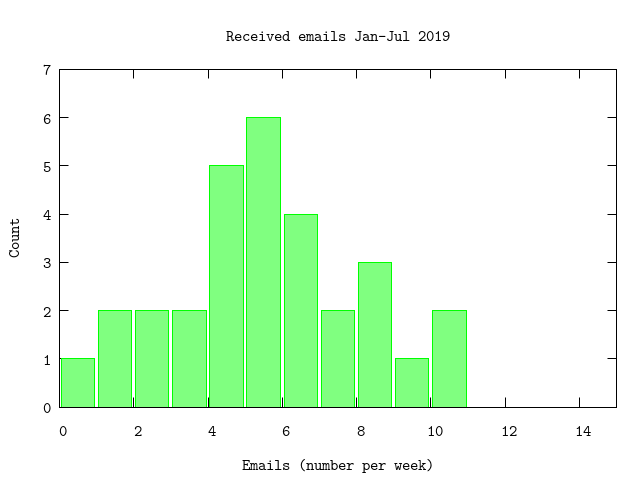

In [131]:
P.histogram(data_janjul,
    plottitle: "Received emails Jan-Jul 2019",
    xlabel: "Emails (number per week)",
    ylabel: "Count",
    xrange: '[0:15]',
    yrange: '[0:7]')
:"this is an inline image"

#### Preparation

In [132]:
# The size of bins for grouping the data
binsize = 1

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
# Initially, search for consistent delivery rates between 1 and 10 emails per week
initial = [{1,10}]

[{1, 10}]

Convert the raw data to bins. In this case we use an offset of 0.5.

In [133]:
hdata = U.to_bins data_janjul, {binsize,0.5}

[{0.5, 0.03333333333333333, 0.004477396381153091, 0.10626509388885415}, {1.5, 0.1, 0.04534643422121238, 0.18800072939009144}, {2.5, 0.16666666666666666, 0.09617216374778598, 0.26379151079819174}, {3.5, 0.23333333333333334, 0.1512514647701126, 0.3362529009260698}, {4.5, 0.4, 0.29969190295754594, 0.5079422422219574}, {5.5, 0.6, 0.49205775777804256, 0.7003080970424541}, {6.5, 0.7333333333333333, 0.6284430129160924, 0.8201238686680054}, {7.5, 0.8, 0.6996385615443061, 0.8766947366046434}, {8.5, 0.9, 0.8119992706099086, 0.9546535657787876}, {9.5, 0.9333333333333333, 0.8517980471244383, 0.9772328358243381}, {10.5, 1.0, 0.9399612673488951, 1.0}]

#### Poisson distribution

In [134]:
model = D.model "poisson"
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		3.482784871775032
    pars:		[5.033261262138547]
    ranges:		{[4.847227027217618, 5.235015346150119]}



:ok

In [135]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
U.display(hdata,model,result,options)

Final:
    chi2:		3.482784858240449
    Degrees of freedom:	10
    gradient:		[0.0]
    parameters:		[5.033284120481718]
    errors:		[0.19648285818555614]
    ranges:
			chi2:		3.482784858240449	-	4.479786058010187
			parameter:	4.847227027217618	-	5.235015346150119


:ok

It shows several results:
* The chi-squared statistic is 0.35 per degree of freedom - which indicates a good description of the data,
* The gradient is really small which indicates that the procedure has found the best possible fit,
* Parameter of 5.0 emails per week (on average),
* An error in the parameter (delivery) of 0.2; meaning the delivery rate is in the range 4.8 - 5.2.

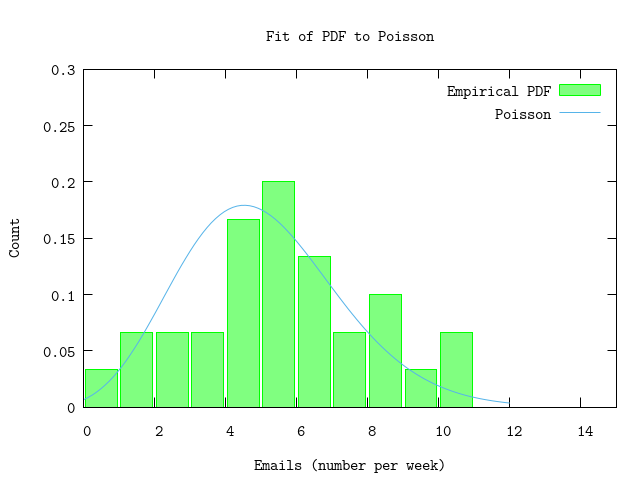

In [136]:
rate = hd(parameters)
pdf = fn x -> :math.pow(rate,x)*:math.exp(-rate)/Math.tgamma(x+1) end
P.pdf(data_janjul,
    plottitle: "Fit of PDF to Poisson",
    xlabel: "Emails (number per week)",
    ylabel: "Count",
    xrange: '[0:15]',
    yrange: '[0:0.30]',
    pdf: pdf,
    offset: 0.5,
    noerrors: true,
    title: "Poisson")
:"this is an inline image"

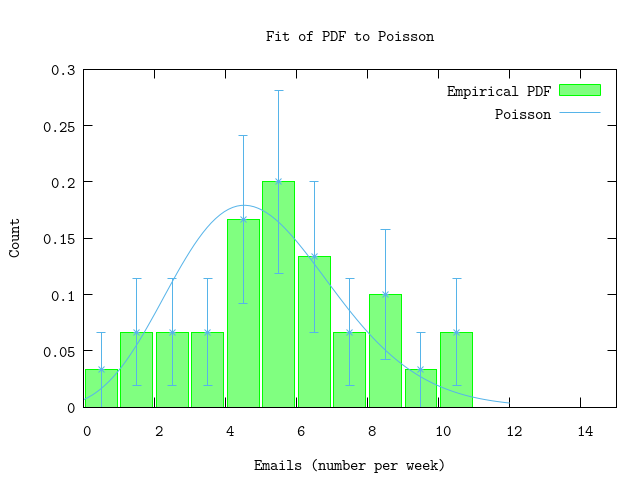

In [137]:
rate = hd(parameters)
pdf = fn x -> :math.pow(rate,x)*:math.exp(-rate)/Math.tgamma(x+1) end
P.pdf(data_janjul,
    plottitle: "Fit of PDF to Poisson",
    xlabel: "Emails (number per week)",
    ylabel: "Count",
    xrange: '[0:15]',
    yrange: '[0:0.30]',
    pdf: pdf,
    offset: 0.5,
    noerrors: false,
    title: "Poisson")
:"this is an inline image"

Let's draw 9 variations of a histogram that all correspond to the same Poisson distribution:

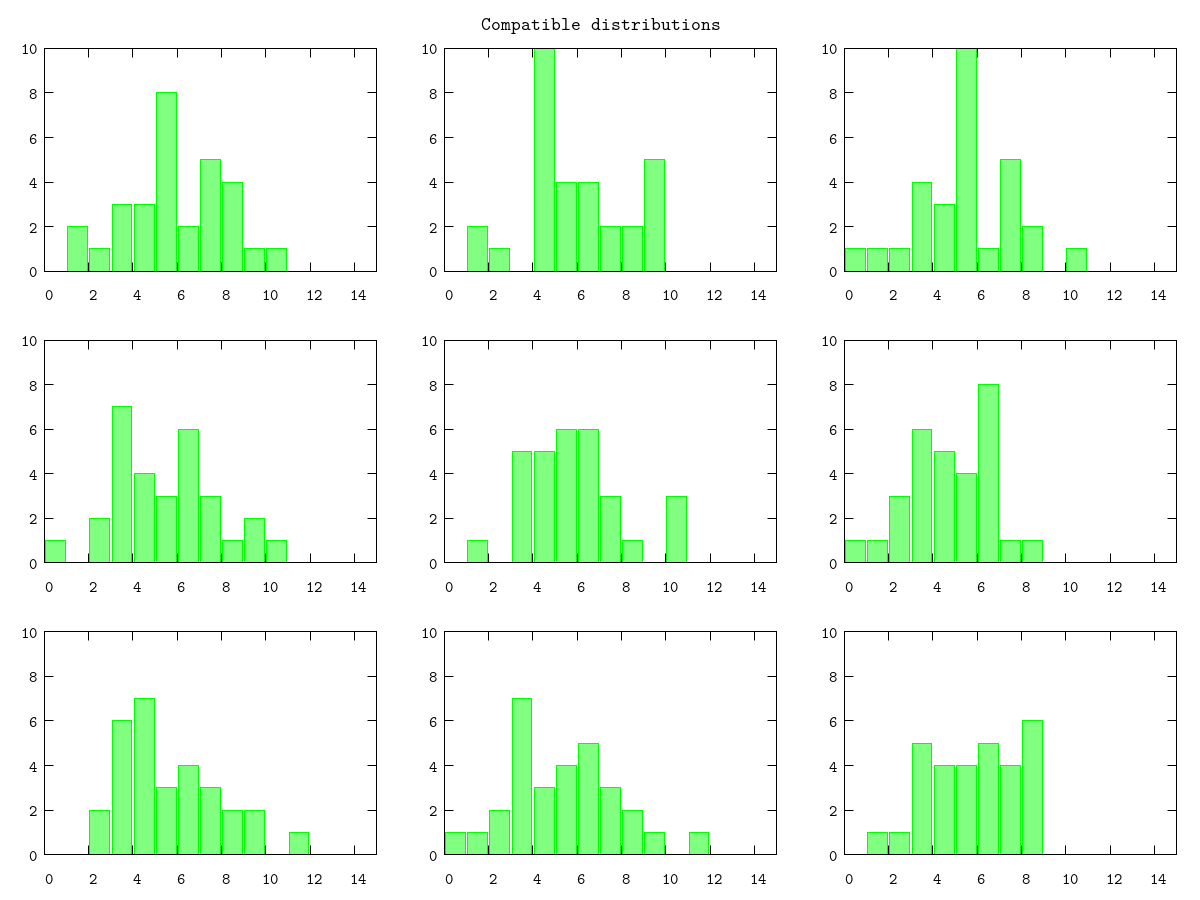

In [138]:
d = ~M(5.03)p
P.multi([
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
  P.histogram(Enum.map(data_janjul,fn _ -> Distribution.random(d) end),xrange: '[0:15]',yrange: '[0:10]', mode: :as_commands),
],
title: "Compatible distributions",
columns: 3,
rows: 3,
size: "1200,900")
:"this is an inline image"

#### August
Now, we include data for the month August. Again, converting to bins.

In [139]:
data_janaug = [6,3,1,0,8,10,5,6,5,7,10,4,3,8,9,8,5,2,1,6,5,4,4,5,7,6,4,2,4,5,1,1,10,10]

[6, 3, 1, 0, 8, 10, 5, 6, 5, 7, 10, 4, 3, 8, 9, 8, 5, 2, 1, 6, 5, 4, 4, 5, 7, 6, 4, 2, 4, 5, 1, 1, 10, 10]

In [140]:
hdata_aug = U.to_bins data_janaug, {binsize,0.5}
:"do not show this result in output"

In [141]:
model = D.model "poisson"
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
result = {_,parameters,_,saved} = F.chi2probe hdata_aug, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		28.30656431609602
    pars:		[5.0617565973866006]
    ranges:		{[4.970408193316791, 5.159193743487926]}



:ok

In [142]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata_aug, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
U.display(hdata_aug,model,result,options)

Final:
    chi2:		28.306560814303925
    Degrees of freedom:	10
    gradient:		[-4.890672932901501e-7]
    parameters:		[5.061935939373805]
    errors:		[0.09584200365325092]
    ranges:
			chi2:		28.306560814303925	-	29.306478804542518
			parameter:	4.970408193316791	-	5.159193743487926


:ok

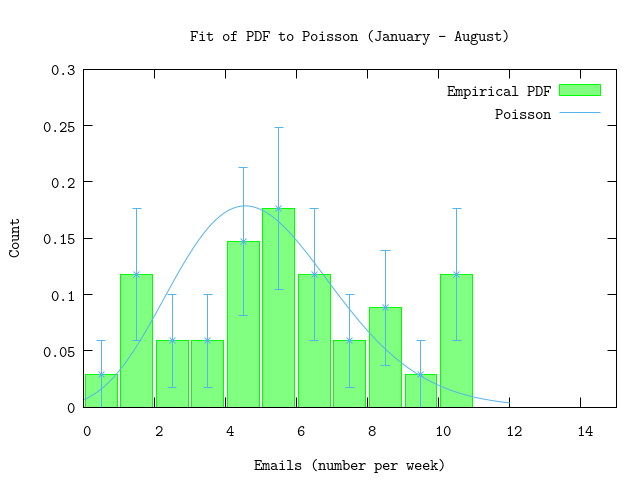

In [143]:
rate = hd(parameters)
pdf = fn x -> :math.pow(rate,x)*:math.exp(-rate)/Math.tgamma(x+1) end
P.pdf(data_janaug,
    plottitle: "Fit of PDF to Poisson (January - August)",
    xlabel: "Emails (number per week)",
    ylabel: "Count",
    xrange: '[0:15]',
    yrange: '[0:0.30]',
    pdf: pdf,
    offset: 0.5,
    noerrors: false,
    title: "Poisson")
:"this is an inline image"

#### Change in delivery rate
Let's see if we can search for the points in the time period at which the chi-squared statistic has a sudden jump in its value.

In [144]:
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
history = 0..length(data_janaug)-1
|> Stream.map(fn i ->
        data_janaug
        |> Enum.slice(0..i)
        |> U.to_bins({binsize,0.5})
        |> F.chi2probe(initial, {Distribution.cdf(model), &F.nopenalties/2}, options)
    end)
|> Stream.map(fn {chi,[par],_,_} -> {chi,par} end)
|> Enum.with_index()
:"do not show this result in output"

In [145]:
history
|> Enum.map(fn {{chi,rate},index} -> [index, Float.round(chi,2), Float.round(rate,1)] end)
|> U.as_table({"Index data point", "Chi-squared", "Delivery Rate"})
:"do not show this result in output"

Index data point|Chi-squared|Delivery Rate
----------------|-----------|-------------
0               |0.0        |1.0          
1               |0.0        |3.4          
2               |0.0        |2.6          
3               |0.04       |1.9          
4               |1.14       |3.1          
5               |6.08       |4.0          
6               |4.79       |4.0          
7               |4.93       |4.2          
8               |3.35       |4.2          
9               |5.19       |4.5          
10              |9.39       |4.9          
11              |7.46       |4.9          
12              |5.52       |4.8          
13              |7.22       |5.0          
14              |11.88      |5.3          
15              |13.36      |5.4          
16              |10.92      |5.4          
17              |9.36       |5.4          
18              |16.99      |5.1          
19              |14.67      |5.1          
20              |12.44      |5.1          
21         

The data shows several jumps at roughly the points 4, 14, and 31.

## Team Mars
Team Mars works with Scrum and in sprints of 2-weeks. The data below is gatherd over the period of 1 year. Each data point is the number of accepted backlog items in the Sprint review meeting.

In [146]:
data_mars = [5,12,4,2,8,5,4,10,4,5,6,6,3,6,5,11,1,5,7,4,4,3,3]

[5, 12, 4, 2, 8, 5, 4, 10, 4, 5, 6, 6, 3, 6, 5, 11, 1, 5, 7, 4, 4, 3, 3]

In [147]:
hdata_mars = U.to_bins data_mars, {binsize,0.5}

[{1.5, 0.043478260869565216, 0.0058447102657877, 0.13689038224309594}, {2.5, 0.08695652173913043, 0.02977628442357071, 0.1905937209791003}, {3.5, 0.21739130434782608, 0.1263699563343216, 0.33774551477037923}, {4.5, 0.43478260869565216, 0.3160946312914347, 0.5600249434832333}, {5.5, 0.6521739130434783, 0.5263221461493021, 0.7626298741894857}, {6.5, 0.782608695652174, 0.6622544852296207, 0.8736300436656784}, {7.5, 0.8260869565217391, 0.709703289667655, 0.9080712005244068}, {8.5, 0.8695652173913043, 0.7585954661422599, 0.9405937209791002}, {10.5, 0.9130434782608695, 0.8094062790208998, 0.9702237155764294}, {11.5, 0.9565217391304348, 0.8631096177569041, 0.9941552897342123}, {12.5, 1.0, 0.9225113769324543, 1.0}]

In [148]:
model = D.model "poisson"
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
result = {_,parameters,_,saved} = F.chi2probe hdata_mars, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		3.7680916885074267
    pars:		[5.46839702708482]
    ranges:		{[5.261651570016543, 5.688949820841141]}



:ok

In [149]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata_mars, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
U.display(hdata_mars,model,result,options)

Final:
    chi2:		3.7680887442307553
    Degrees of freedom:	10
    gradient:		[1.1632233868117097e-9]
    parameters:		[5.468026377364132]
    errors:		[0.2159980613408994]
    ranges:
			chi2:		3.7680887442307553	-	4.764778869401112
			parameter:	5.261651570016543	-	5.688949820841141


:ok

In [150]:
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
history = 0..length(data_mars)-1
|> Stream.map(fn i ->
        data_mars
        |> Enum.slice(0..i)
        |> U.to_bins({binsize,0.5})
        |> F.chi2probe(initial, {Distribution.cdf(model), &F.nopenalties/2}, options)
    end)
|> Stream.map(fn {chi,[par],_,_} -> {chi,par} end)
|> Enum.with_index()
:"do not show this result in output"

In [152]:
history
|> Enum.map(fn {{chi,rate},index} -> [index, Float.round(chi,2), Float.round(rate,1)] end)
|> U.as_table({"Index data point", "Chi-squared", "Delivery Rate"})
:"do not show this result in output"

Index data point|Chi-squared|Delivery Rate
----------------|-----------|-------------
0               |0.0        |1.0          
1               |0.0        |5.7          
2               |0.01       |5.2          
3               |0.01       |4.4          
4               |0.07       |5.3          
5               |0.1        |5.2          
6               |0.1        |4.9          
7               |0.69       |5.8          
8               |0.97       |5.6          
9               |1.04       |5.5          
10              |0.55       |5.5          
11              |0.36       |5.5          
12              |0.55       |5.4          
13              |0.56       |5.5          
14              |0.84       |5.4          
15              |2.55       |6.0          
16              |3.18       |5.8          
17              |3.41       |5.8          
18              |2.28       |5.8          
19              |2.59       |5.7          
20              |3.0        |5.6          
21         

This shows a stable chi-squared fit for the entire period. There is a jump in the chi-squared value at 15 but since the fit is good anyway (less than 1 pre degree of freedom) this is not significant.

## Team Jupiter
Team Jupiter works with Scrum and in sprints of 2-weeks. The data below is gatherd over the period of 1 year. Each data point is the number of accepted backlog items in the Sprint review meeting.

In [153]:
data_jup = [53, 50, 53, 48, 69, 39, 12, 17, 21, 15, 15, 31, 62, 78, 23, 17, 25, 28, 38, 16]

[53, 50, 53, 48, 69, 39, 12, 17, 21, 15, 15, 31, 62, 78, 23, 17, 25, 28, 38, 16]

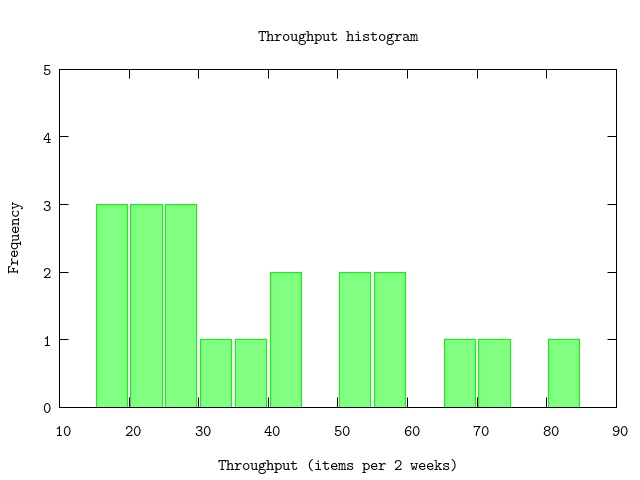

In [154]:
P.histogram(data_jup,
    bin: 5,
    plottitle: "Throughput histogram",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:5]')
:"this is an inline image"

#### Analysis
Automatically find the trends in the data.

In [155]:
# Generate a countless number of intervals. The intervals alternate between 1-15 (inclusive) of the month,
# and the 16-end of the month.
intervals = U.intervals(end: ~D[2019-05-01])

model = D.model "poisson"
options = [model: :linear, bin: binsize, fitmodel: model, probes: 10_000, init: [{0.1,100}]]

# Find points in the delivery dates that indicate a change in the model
trends = F.find_all(data_jup, options) |> Enum.into([])
:"do not show this result in output"

In [156]:
trends
|> Stream.transform(1, fn arg={_,_,data_jup}, index ->
    { [{arg, Enum.at(intervals,index)}], index+length(data_jup) }
  end)
|> Enum.map(fn {{chi, [rate], sub}, date} ->
    [
      Timex.format!(date,~S({Mshort} {D}, {YYYY})),
      Float.round(chi,4),
      Float.round(rate,1),
      "#{inspect(sub, charlists: :as_lists)}"
    ]
  end)
|> U.as_table({"End date of sequence", "Goodness of fit", "Delivery Rate", "Subsequence"})
:"do not show this result in output"

End date of sequence|Goodness of fit|Delivery Rate|Subsequence             
--------------------|---------------|-------------|------------------------
Apr 16, 2019        |0.2367         |49.6         |[53, 50, 53, 48, 69, 39]
Jan 16, 2019        |0.0262         |16.1         |[12, 17, 21, 15, 15, 31]
Oct 16, 2018        |0.0003         |62.4         |[62, 78]                
Sep 16, 2018        |0.5107         |22.0         |[23, 17, 25, 28, 38, 16]


It reports the dates where the jumps occur including the data sequence corresponding to them.

#### Split of data in multiple time periods

In [157]:
data_jup_1 = [62, 78, 23, 17, 25, 28, 38, 16]
data_jup_2 = [12, 17, 21, 15, 15, 31]
data_jup_3 = [53, 50, 53, 48, 69, 39]

'5250E\''

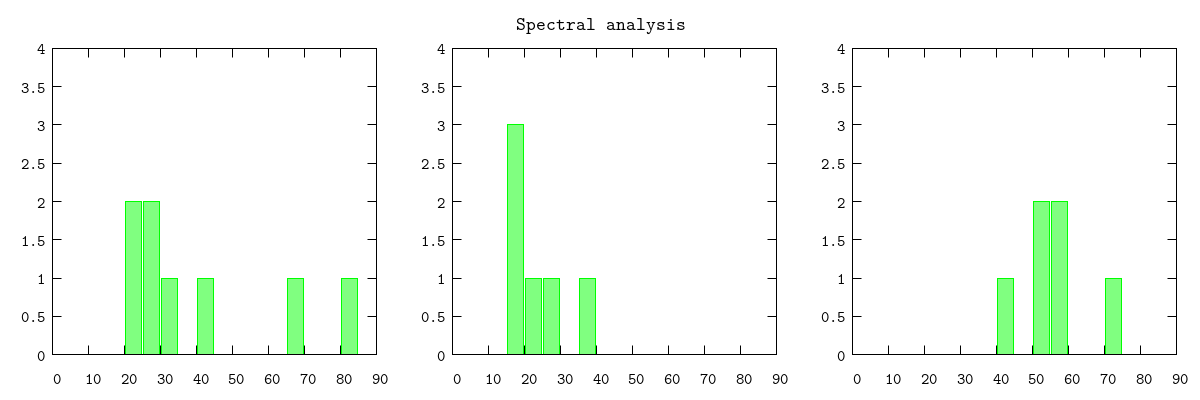

In [158]:
P.multi([
  P.histogram(data_jup_1, bin: 5, yrange: '[0:4]', xrange: '[0:90]', mode: :as_commands),
  P.histogram(data_jup_2, bin: 5, yrange: '[0:4]', xrange: '[0:90]', mode: :as_commands),
  P.histogram(data_jup_3, bin: 5, yrange: '[0:4]', xrange: '[0:90]', mode: :as_commands)  
],
title: "Spectral analysis",
columns: 3,
rows: 1,
size: "1200,400")
:"this is an inline image"